<a href="https://colab.research.google.com/github/ccouzinet/ml_experiments/blob/main/nn_calibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network calibration

According to what I saw on the internet and this article (https://arxiv.org/pdf/1706.04599.pdf), we often mistake the output of softmax function (usually the last activation function determining the output score) for a probabilty as it relies in the [0, 1] interval.

However, networks tend to over-estimate their scores and their prediction is not calibrated. Thus, if the network predicts a certain value with a 20% score, it does not necessarily means that the output value has 20% chance to be true ; it cannot be interpretated as a confidence level.

In certain critical fields such as autonomous driving or medical imagery, this calibration is essential.

In the following notebook, I only use the TemperatureScaling post-processing as it is described as very efficient in the paper.

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import tensorflow_datasets as tfds

Found GPU at: /device:GPU:0


In [7]:
!pip install netcal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 4.4 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 718 kB 63.7 MB/s 


In [31]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteYOHV3G/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteYOHV3G/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [32]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [33]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


In [37]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(10),
  tf.keras.layers.Softmax()
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=15,
    validation_data=ds_test,
)


Epoch 1/15
391/391 [==============================] - 2s 4ms/step - loss: 2.0274 - sparse_categorical_accuracy: 0.2513 - val_loss: 1.8576 - val_sparse_categorical_accuracy: 0.3247
Epoch 2/15
391/391 [==============================] - 2s 4ms/step - loss: 1.8135 - sparse_categorical_accuracy: 0.3421 - val_loss: 1.7398 - val_sparse_categorical_accuracy: 0.3757
Epoch 3/15
391/391 [==============================] - 2s 4ms/step - loss: 1.7214 - sparse_categorical_accuracy: 0.3772 - val_loss: 1.6990 - val_sparse_categorical_accuracy: 0.3887
Epoch 4/15
391/391 [==============================] - 2s 4ms/step - loss: 1.6655 - sparse_categorical_accuracy: 0.3983 - val_loss: 1.6148 - val_sparse_categorical_accuracy: 0.4233
Epoch 5/15
391/391 [==============================] - 2s 4ms/step - loss: 1.6126 - sparse_categorical_accuracy: 0.4188 - val_loss: 1.5961 - val_sparse_categorical_accuracy: 0.4274
Epoch 6/15
391/391 [==============================] - 2s 4ms/step - loss: 1.5750 - sparse_categorica

In [38]:
print(model.evaluate(ds_train))
confidences = model.predict(ds_test)
confidences.max()

391/391 [==============================] - 1s 3ms/step - loss: 1.3740 - sparse_categorical_accuracy: 0.5086
[1.3739957809448242, 0.508620023727417]


0.9986333

In [39]:
import numpy as np
ground_truth = np.concatenate([y for x, y in ds_test], axis=0)
ground_truth

array([7, 0, 6, ..., 8, 6, 0])

In [40]:
from netcal.scaling import TemperatureScaling

temperature = TemperatureScaling()
temperature.fit(confidences, ground_truth)
calibrated = temperature.transform(confidences)

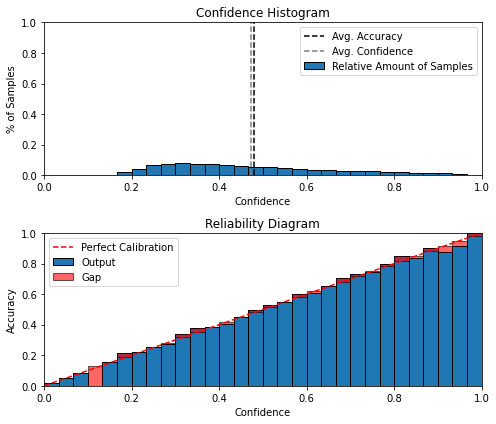

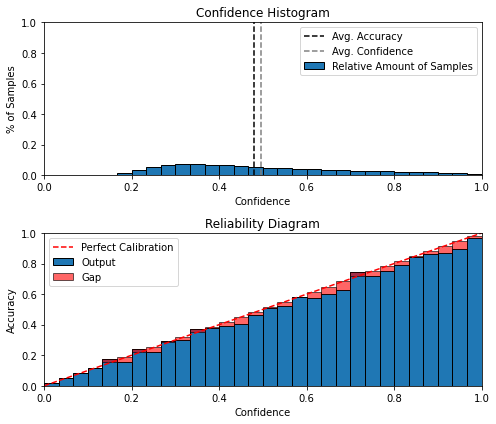

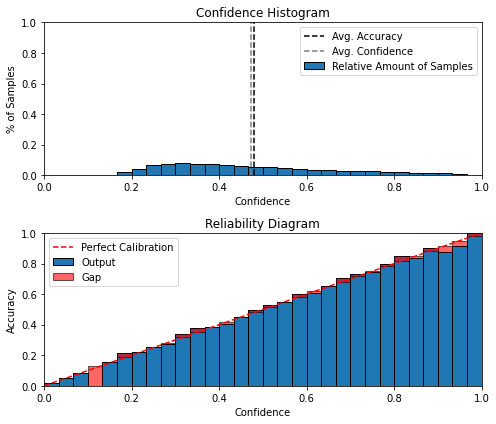

In [41]:
from netcal.presentation import ReliabilityDiagram

n_bins = 30

diagram = ReliabilityDiagram(n_bins)
diagram.plot(confidences, ground_truth)  # visualize miscalibration of uncalibrated
diagram.plot(calibrated, ground_truth)  